# Expanded Non-Consensus Case: Perfectly Opposing Agendas

#### Unified Model with Multiple Strategic Agents
#### Strategic Agent-Specific Message Weights
#### Highly Symmetric Network

James Yu, 19 March 2023

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def should_terminate(bundles, eps):
    return all([np.allclose(b[0], b[1], rtol = eps, atol = eps) for b in bundles])

def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    eps = np.sqrt(np.finfo(np.float64).eps)
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        historical_K.insert(0, K_new)
        historical_k.insert(0, k_new)
        historical_kappa.insert(0, kappa_new)
        if should_terminate([(K_t, K_new), (k_t, k_new), (kappa_t, kappa_new)], eps):
            return historical_K[0], historical_k[0], historical_kappa[0]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new

In [5]:
def optimal(X_init, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, eps):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(int)
    
    M_ = M(K_ss, B, R, L, delta)
    H_ = H(B, K_ss, A, L)
    E_ = E(M_, H_)
    G_ = G(A, B, E_, L, n)
    F_ = [F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n) for l in range(L)]
    g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
    
    i = 0
    while True:
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if l == L - 1 and np.allclose(X_t[l], X_new, rtol = eps, atol = eps):
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, b1, b2, a1, a2, delta = 0.9, c = 200, X_0_1 = np.array([[10.0, -2.0, 5.0]], ndmin = 2).T, print_ = True, tol = np.sqrt(np.finfo(np.float64).eps)):
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    n = 3 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c * np.identity(n), c * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol)
    xs, rs, payoffs = optimal(X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, tol)
    if print_:
        print("Steady-State Opinions:")
        print((xs[0][-1] + b1).T)
        print("K^* (1, 2):")
        print(K_ss[0])
        print(K_ss[1])
        print("k^* (1, 2):")
        print(k_ss[0])
        print(k_ss[1])
        print("kappa^* (1, 2):")
        print(kappa_ss[0])
        print(kappa_ss[1])
        print("Terminal messages (1, 2):")
        print(rs[0][-1].T)
        print(rs[1][-1].T)
        return xs, rs, payoffs
    if print_ == False:
        return xs[0][-1] + b1

In [7]:
def do_ensemble(A, X_0_1 = np.array([[10.0, -2.0, 5.0]], ndmin = 2).T):
    xs, rs, payoffs = run_simulation(A, 10, -10, 10.0, 5.0, c = 0.1, delta = 0.9, X_0_1 = X_0_1)
    return (xs, rs, payoffs)

In [8]:
def show_opinions(res, labels):
    for l, r in enumerate(res):
        xs, rs, payoffs = r
        for j in range(3):
            """
            IMPORTANT: the 10 below comes from the agenda bias
            """
            plt.plot(range(len(xs[0])), [xs[0][i][j]+(10) for i in range(len(xs[0]))], label = f"Agent {j+1}, {labels[l]}")

    plt.xlabel("Time ($t$)")
    plt.ylabel("Naive Agent Opinion ($x_t$)")
    plt.legend()
    plt.title("Opinion Evolution")
    plt.show()

In [9]:
def show_messages(res, k, labels):
    for l, r in enumerate(res):
        xs, rs, payoffs = r
        for j in range(3):
            plt.plot(range(len(rs[k])), [rs[k][i][j] for i in range(len(rs[k]))], label = f"To Agent {j+1}, {labels[l]}")
    plt.xlabel("Time")
    plt.ylabel("Message")
    plt.legend()
    plt.title(f"Messages: Strategic Agent {k}")
    plt.show()

In [10]:
A1 = np.array([ # opinion leader highly symmetric
    [0.5, 0.3, 0.2],
    [0.5, 0.3, 0.2],
    [0.5, 0.3, 0.2]
])

# column 3 is fixed. part of column 2 is shifted into column 1
A2 = np.array([
    [0.6, 0.2, 0.2],
    [0.6, 0.2, 0.2],
    [0.6, 0.2, 0.2]
])

print(A1)
res1 = do_ensemble(A1)
print()
print(A2)
res2 = do_ensemble(A2)

[[0.5 0.3 0.2]
 [0.5 0.3 0.2]
 [0.5 0.3 0.2]]
Steady-State Opinions:
[[9.63966003 8.18477887 7.45733829]]
K^* (1, 2):
[[1.00047977 0.00028786 0.00019191]
 [0.00028786 1.00017272 0.00011515]
 [0.00019191 0.00011515 1.00007676]]
[[1.00012023 0.00007214 0.00004809]
 [0.00007214 1.00004328 0.00002885]
 [0.00004809 0.00002885 1.00001924]]
k^* (1, 2):
[[-12.14414874  -7.28648925  -4.8576595 ]]
[[12.17267722  7.30360633  4.86907089]]
kappa^* (1, 2):
[[-776964.08078701]]
[[-3116646.74378222]]
Terminal messages (1, 2):
[[579.02379447 491.32581991 447.47683263]]
[[-1157.8730032   -982.76803031  -895.21554386]]

[[0.6 0.2 0.2]
 [0.6 0.2 0.2]
 [0.6 0.2 0.2]]
Steady-State Opinions:
[[10.36706016  7.45758327  7.45758327]]
K^* (1, 2):
[[1.00069087 0.00023029 0.00023029]
 [0.00023029 1.00007676 0.00007676]
 [0.00023029 0.00007676 1.00007676]]
[[1.00017313 0.00005771 0.00005771]
 [0.00005771 1.00001924 0.00001924]
 [0.00005771 0.00001924 1.00001924]]
k^* (1, 2):
[[-14.57285358  -4.85761786  -4.85761786

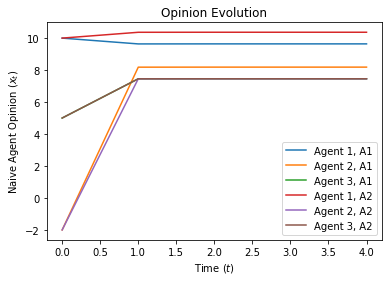

In [11]:
show_opinions((res1, res2), ("A1", "A2"))

No change to naive agent 3. This is also the agent whose column did not change.

Agent 2 in the A2 model, who has an identical column to agent 3, has a limit opinion identical to that of agent 3.

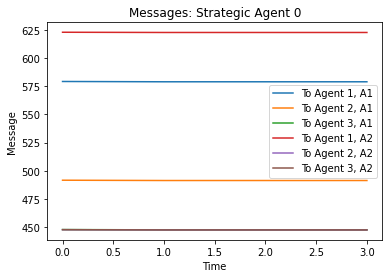

In [12]:
show_messages((res1, res2), 0, ("A1", "A2"))

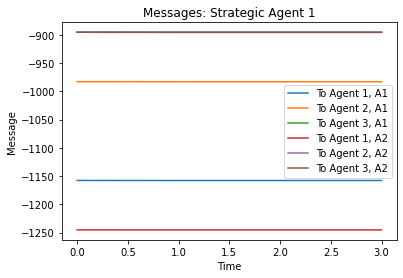

In [13]:
show_messages((res1, res2), 1, ("A1", "A2"))

Now suppose none of the agents have the same columns as before:

In [14]:
A1 # to compare

array([[0.5, 0.3, 0.2],
       [0.5, 0.3, 0.2],
       [0.5, 0.3, 0.2]])

In [15]:
A3 = np.array([ # 1 up, 2 down, 3 down
    [0.7, 0.25, 0.05],
    [0.7, 0.25, 0.05],
    [0.7, 0.25, 0.05]
])

print(A3)
res3 = do_ensemble(A3)

[[0.7  0.25 0.05]
 [0.7  0.25 0.05]
 [0.7  0.25 0.05]]
Steady-State Opinions:
[[11.09421514  7.82166891  6.36720393]]
K^* (1, 2):
[[1.00094035 0.00033584 0.00006717]
 [0.00033584 1.00011994 0.00002399]
 [0.00006717 0.00002399 1.0000048 ]]
[[1.00023565 0.00008416 0.00001683]
 [0.00008416 1.00003006 0.00000601]
 [0.00001683 0.00000601 1.0000012 ]]
k^* (1, 2):
[[-17.00138328  -6.0719226   -1.21438452]]
[[17.04008937  6.0857462   1.21714924]]
kappa^* (1, 2):
[[-810344.99475011]]
[[-3250865.56693592]]
Terminal messages (1, 2):
[[666.57808192 469.28459918 381.59860685]]
[[-1332.94526641  -939.01281018  -763.93171853]]


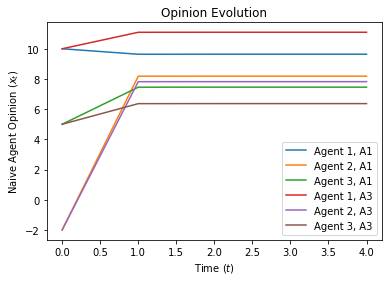

In [16]:
show_opinions((res1, res3), ("A1", "A3"))

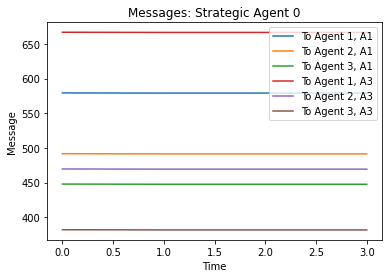

In [17]:
show_messages((res1, res3), 0, ("A1", "A3"))

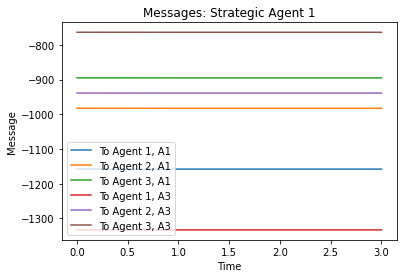

In [18]:
show_messages((res1, res3), 1, ("A1", "A3"))

At the moment, the agent being hit with the most weight is agent 1. If we instead change the initial opinions:

In [19]:
X_0_1_alt = np.array([[5.0, -2.0, 10.0]], ndmin = 2).T # swap agents 1 and 3

print(A1)
res1_alt = do_ensemble(A1, X_0_1 = X_0_1_alt)
print()
print(A2)
res2_alt = do_ensemble(A2, X_0_1 = X_0_1_alt)

[[0.5 0.3 0.2]
 [0.5 0.3 0.2]
 [0.5 0.3 0.2]]
Steady-State Opinions:
[[9.63966003 8.18477887 7.45733829]]
K^* (1, 2):
[[1.00047977 0.00028786 0.00019191]
 [0.00028786 1.00017272 0.00011515]
 [0.00019191 0.00011515 1.00007676]]
[[1.00012023 0.00007214 0.00004809]
 [0.00007214 1.00004328 0.00002885]
 [0.00004809 0.00002885 1.00001924]]
k^* (1, 2):
[[-12.14414874  -7.28648925  -4.8576595 ]]
[[12.17267722  7.30360633  4.86907089]]
kappa^* (1, 2):
[[-776964.08078701]]
[[-3116646.74378222]]
Terminal messages (1, 2):
[[579.02379447 491.32581991 447.47683263]]
[[-1157.8730032   -982.76803031  -895.21554386]]

[[0.6 0.2 0.2]
 [0.6 0.2 0.2]
 [0.6 0.2 0.2]]
Steady-State Opinions:
[[10.36706016  7.45758327  7.45758327]]
K^* (1, 2):
[[1.00069087 0.00023029 0.00023029]
 [0.00023029 1.00007676 0.00007676]
 [0.00023029 0.00007676 1.00007676]]
[[1.00017313 0.00005771 0.00005771]
 [0.00005771 1.00001924 0.00001924]
 [0.00005771 0.00001924 1.00001924]]
k^* (1, 2):
[[-14.57285358  -4.85761786  -4.85761786

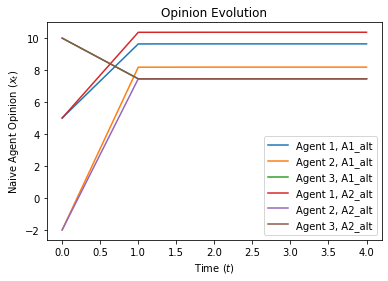

In [20]:
show_opinions((res1_alt, res2_alt), ("A1_alt", "A2_alt"))

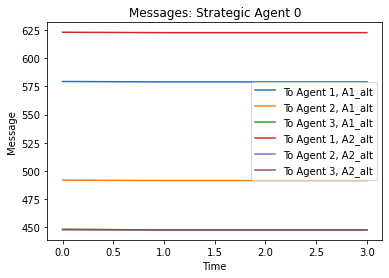

In [21]:
show_messages((res1_alt, res2_alt), 0, ("A1_alt", "A2_alt"))

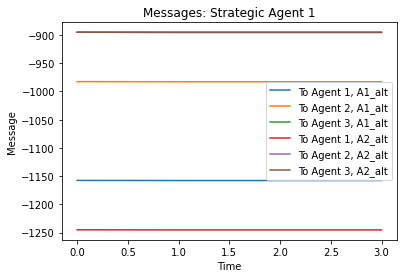

In [22]:
show_messages((res1_alt, res2_alt), 1, ("A1_alt", "A2_alt"))

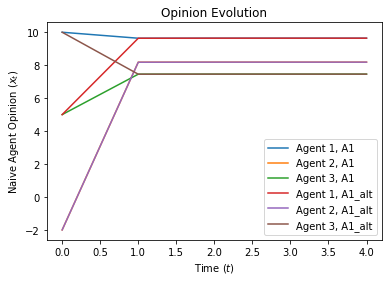

In [23]:
show_opinions((res1, res1_alt), ("A1", "A1_alt"))

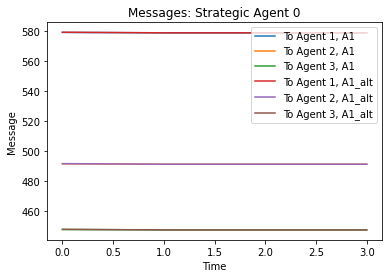

In [24]:
show_messages((res1, res1_alt), 0, ("A1", "A1_alt"))

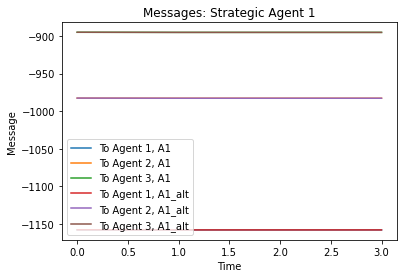

In [25]:
show_messages((res1, res1_alt), 1, ("A1", "A1_alt"))

All that happens is the trajectories of the opinions swap initial points. Everything else remains the same. Instead, let's try changing who the opinion leader is:

In [26]:
A4 = np.array([
    [0.3, 0.5, 0.2],
    [0.3, 0.5, 0.2],
    [0.3, 0.5, 0.2]
])
print(A4)
res4 = do_ensemble(A4)

[[0.3 0.5 0.2]
 [0.3 0.5 0.2]
 [0.3 0.5 0.2]]
Steady-State Opinions:
[[8.18477887 9.63966003 7.45733829]]
K^* (1, 2):
[[1.00017272 0.00028786 0.00011515]
 [0.00028786 1.00047977 0.00019191]
 [0.00011515 0.00019191 1.00007676]]
[[1.00004328 0.00007214 0.00002885]
 [0.00007214 1.00012023 0.00004809]
 [0.00002885 0.00004809 1.00001924]]
k^* (1, 2):
[[ -7.28648925 -12.14414874  -4.8576595 ]]
[[ 7.30360633 12.17267722  4.86907089]]
kappa^* (1, 2):
[[-776964.08078706]]
[[-3116646.74378241]]
Terminal messages (1, 2):
[[491.32581991 579.02379447 447.47683263]]
[[ -982.76803031 -1157.8730032   -895.21554386]]


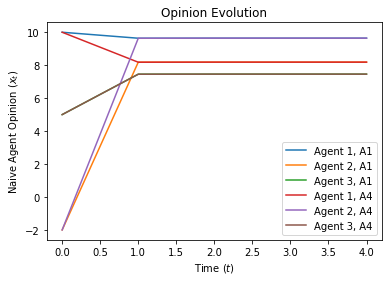

In [27]:
show_opinions((res1, res4), ("A1", "A4"))

For strategic agent 1 (0):

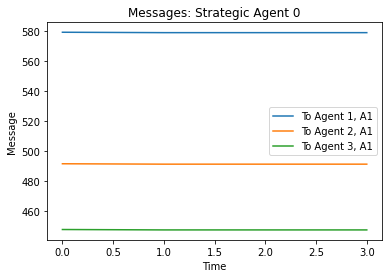

In [28]:
show_messages((res1,), 0, ("A1",))

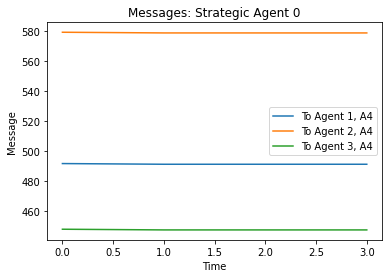

In [29]:
show_messages((res4,), 0, ("A4",))

For strategic agent 2 (1):

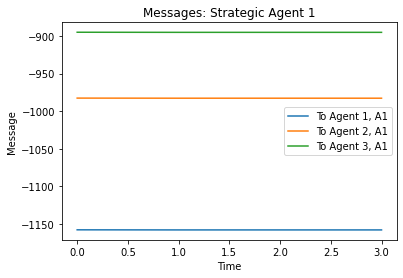

In [30]:
show_messages((res1,), 1, ("A1",))

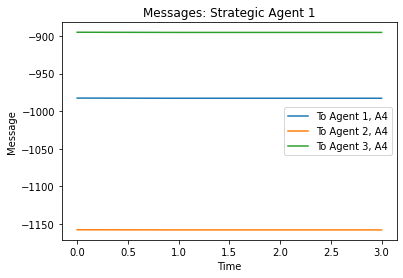

In [31]:
show_messages((res4,), 1, ("A4",))

With the initial opinions fixed in place, the magnitudes of everything remain the same. All that happens is that the indices swap, and the most-targeted agent is the one with the highest weight.

Now let's try setting the initial opinions to something entirely different:

In [32]:
X_0_1_alt2 = np.array([[1.0, 2.0, 3.0]], ndmin = 2).T

print(A1)
res1_alt2 = do_ensemble(A1, X_0_1 = X_0_1_alt2)

[[0.5 0.3 0.2]
 [0.5 0.3 0.2]
 [0.5 0.3 0.2]]
Steady-State Opinions:
[[9.63966003 8.18477887 7.45733829]]
K^* (1, 2):
[[1.00047977 0.00028786 0.00019191]
 [0.00028786 1.00017272 0.00011515]
 [0.00019191 0.00011515 1.00007676]]
[[1.00012023 0.00007214 0.00004809]
 [0.00007214 1.00004328 0.00002885]
 [0.00004809 0.00002885 1.00001924]]
k^* (1, 2):
[[-12.14414874  -7.28648925  -4.8576595 ]]
[[12.17267722  7.30360633  4.86907089]]
kappa^* (1, 2):
[[-776964.08078701]]
[[-3116646.74378222]]
Terminal messages (1, 2):
[[579.02379447 491.32581991 447.47683263]]
[[-1157.8730032   -982.76803031  -895.21554386]]


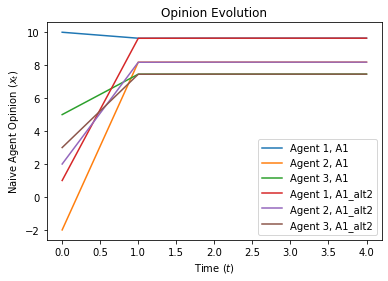

In [33]:
show_opinions((res1, res1_alt2), ("A1", "A1_alt2"))

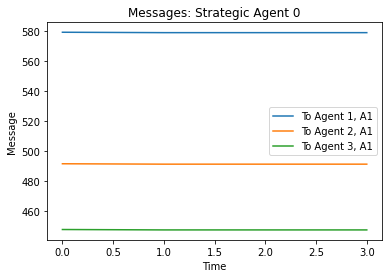

In [34]:
show_messages((res1,), 0, ("A1",))

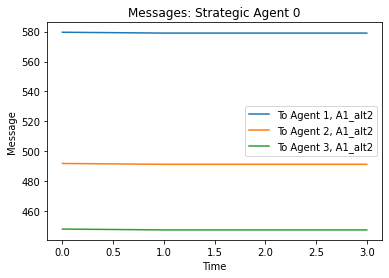

In [35]:
show_messages((res1_alt2,), 0, ("A1_alt2",))

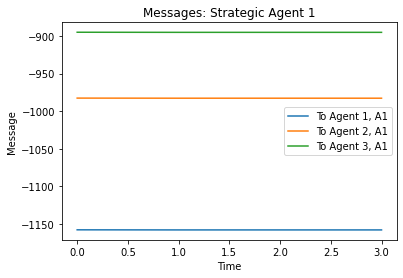

In [36]:
show_messages((res1,), 1, ("A1",))

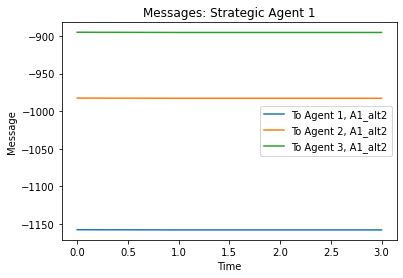

In [37]:
show_messages((res1_alt2,), 1, ("A1_alt2",))

And if we set them to all be the same:

In [38]:
X_0_1_alt3 = np.array([[0.0, 0.0, 0.0]], ndmin = 2).T

print(A1)
res1_alt3 = do_ensemble(A1, X_0_1 = X_0_1_alt3)

[[0.5 0.3 0.2]
 [0.5 0.3 0.2]
 [0.5 0.3 0.2]]
Steady-State Opinions:
[[9.63966003 8.18477887 7.45733829]]
K^* (1, 2):
[[1.00047977 0.00028786 0.00019191]
 [0.00028786 1.00017272 0.00011515]
 [0.00019191 0.00011515 1.00007676]]
[[1.00012023 0.00007214 0.00004809]
 [0.00007214 1.00004328 0.00002885]
 [0.00004809 0.00002885 1.00001924]]
k^* (1, 2):
[[-12.14414874  -7.28648925  -4.8576595 ]]
[[12.17267722  7.30360633  4.86907089]]
kappa^* (1, 2):
[[-776964.08078701]]
[[-3116646.74378222]]
Terminal messages (1, 2):
[[579.02379447 491.32581991 447.47683263]]
[[-1157.8730032   -982.76803031  -895.21554386]]


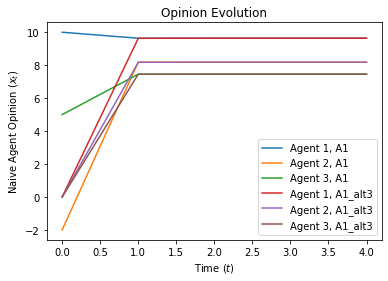

In [39]:
show_opinions((res1, res1_alt3), ("A1", "A1_alt3"))

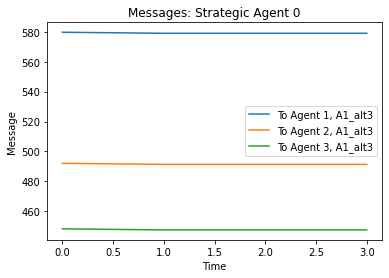

In [40]:
show_messages((res1_alt3,), 0, ("A1_alt3",))

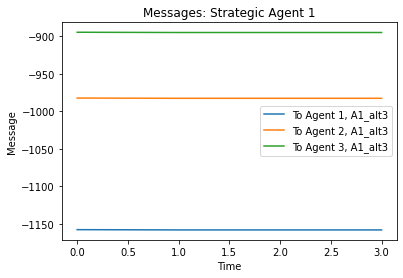

In [41]:
show_messages((res1_alt3,), 1, ("A1_alt3",))